# 0.0. IMPORTS

In [82]:
# Manipulação
import re
import statistics
import pandas               as pd
import numpy                as np
from scipy                         import stats       as ss

# Visualização
import matplotlib.pyplot as plt
import matplotlib.gridspec                            as gs
import seaborn as sns
from IPython.display               import Image

# Machine Learning
from sklearn.model_selection       import train_test_split
from boruta                        import BorutaPy
from sklearn.linear_model          import LogisticRegression
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import StratifiedKFold
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.model_selection       import RandomizedSearchCV
from lightgbm                      import LGBMClassifier
from sklearn                       import naive_bayes           as nb
from sklearn                       import ensemble              as en
import catboost           as cb
import xgboost            as xgb

## 0.1. Funcoes Auxiliares

In [2]:
# Configuração do notebook
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()

# Contador de colunas
def cont_columns(first_value, df):
    cont = 0
    for value in df.columns:
        if value.split('-')[0] == first_value:
            cont += 1
    print(f'Número de colunas {first_value}-#:{cont}')

# Cramer_v: cálculo de correlação entre variáveis categóricas
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1)))

In [3]:
jupyter_settings()

## 0.2. Dados

In [4]:
# Import dos experimentos
df_exp = pd.read_csv('https://github.com/tadeucbm/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true', compression = 'zip')

# Import dos resultados
df_result = pd.read_csv('https://github.com/tadeucbm/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true')

In [5]:
df_exp.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [6]:
df_result

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1.0. DESCRIÇÃO DOS DADOS

O objetivo da descrição dos dados é obter uma visão geral do dados que estamos trabalhando. Nesse estágio inicial iremos seguir as seguintes etapas:
- **Dimensão dos Dados:** Encontrar a quantidade de linhas e colunas;
- **Tipo dos Dados:** Cada coluna possui um tipo específico(Booleano, String, Int ou Float). Para uma melhor análise e resolução de possíveis divergências, essa informação é importante;
- **Valores Faltantes:** Na vida real nem sempre teremos dados livres de incoerências. Os valores faltantes são aqueles que por algum motivo não foram colocados. É importante analisar o contexto para tratar esse dados;
- **Descrição das Colunas**: Descobrir os valores únicos;
- **Descrição Estatística:** Uma descrição básica dos dados. O objetivo é entender de maneira ampla o funcionamento das variáveis;
- **Entendimento:** Qual o significado dos dados?

## 1.1. Dimensão dos Dados

### Experimentos

In [7]:
print(f'Número de linhas:{df_exp.shape[0]}')
print(f'Número de colunas:{df_exp.shape[1]}')

Número de linhas:23814
Número de colunas:877


In [8]:
# Contando o número de valores 'g-#'
cont_columns('g', df_exp)

# Contando o número de valores 'c-#'
cont_columns('c', df_exp)

Número de colunas g-#:772
Número de colunas c-#:100


### Resultados

In [9]:
print(f'Número de linhas:{df_result.shape[0]}')
print(f'Número de colunas:{df_result.shape[1]}')

Número de linhas:23814
Número de colunas:207


## 1.2. Tipo dos Dados

### Experimentos

In [10]:
df_exp.dtypes[[0, 1, 2, 3, 4, 5, 777]]

id             object
tratamento     object
tempo           int64
dose           object
droga          object
g-0           float64
c-0           float64
dtype: object

### Resultados

In [11]:
df_result.dtypes

id                                       object
5-alpha_reductase_inhibitor               int64
11-beta-hsd1_inhibitor                    int64
acat_inhibitor                            int64
acetylcholine_receptor_agonist            int64
                                          ...  
ubiquitin_specific_protease_inhibitor     int64
vegfr_inhibitor                           int64
vitamin_b                                 int64
vitamin_d_receptor_agonist                int64
wnt_inhibitor                             int64
Length: 207, dtype: object

## 1.3. Valores Faltantes

### Experimentos

In [12]:
df_exp.isna().sum().sort_values(ascending=True)

id       0
g-572    0
g-573    0
g-574    0
g-575    0
        ..
g-291    0
g-292    0
g-293    0
g-282    0
c-99     0
Length: 877, dtype: int64

### Resultados

In [13]:
df_result.isna().sum().sort_values(ascending=True)

id                                      0
monoacylglycerol_lipase_inhibitor       0
monoamine_oxidase_inhibitor             0
monopolar_spindle_1_kinase_inhibitor    0
mtor_inhibitor                          0
                                       ..
cyclooxygenase_inhibitor                0
cytochrome_p450_inhibitor               0
dihydrofolate_reductase_inhibitor       0
cdk_inhibitor                           0
wnt_inhibitor                           0
Length: 207, dtype: int64

Os dados não possuem valores faltantes.

## 1.4. Descrição das Colunas

### Experimentos

#### Valores Únicos

In [14]:
for col in df_exp.columns:
    if len(df_exp[col].unique()) < 10:
        print(f'{col}: {df_exp[col].unique()}')

tratamento: ['com_droga' 'com_controle']
tempo: [24 72 48]
dose: ['D1' 'D2']


As demais colunas são valores continuos ou identificadores.

####  Proporções

In [15]:
for col in df_exp.columns:
    if len(df_exp[col].unique()) < 10:
        print(col)
        print(f'{df_exp[col].value_counts(normalize=True)}')
        print()

tratamento
com_droga       0.921643
com_controle    0.078357
Name: tratamento, dtype: float64

tempo
48    0.346435
72    0.327202
24    0.326363
Name: tempo, dtype: float64

dose
D1    0.510078
D2    0.489922
Name: dose, dtype: float64



### Resultados

Na tabela de resultados, os valores são binários. Eles podem ser classificados em 1 (reage) ou 0 (não reage)

## 1.5. Descrição Estatística

### Variáveis Contínuas

In [16]:
# Separando as variáveis contínuas
var_cont = df_exp.iloc[:, 5:]

In [17]:
# Medidas de Tendência Central - mean, meadina 
ct1 = pd.DataFrame(var_cont.apply(np.mean)).T
ct2 = pd.DataFrame(var_cont.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(var_cont.apply(np.std)).T 
d2 = pd.DataFrame(var_cont.apply(min)).T 
d3 = pd.DataFrame(var_cont.apply(max)).T 
d4 = pd.DataFrame(var_cont.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(var_cont.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(var_cont.apply(lambda x: x.kurtosis())).T 

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,g-0,-5.513,10.000,15.513,0.248366,-0.00885,1.393369,2.790270,11.332955
1,g-1,-5.737,5.039,10.776,-0.095684,-0.04660,0.812346,-0.169398,2.305161
2,g-2,-9.104,8.257,17.361,0.152253,0.07520,1.035710,0.361242,3.893016
3,g-3,-5.998,10.000,15.998,0.081971,0.00805,0.949992,1.816132,10.988063
4,g-4,-6.369,10.000,16.369,0.057347,-0.02690,1.032070,1.092531,6.895809
...,...,...,...,...,...,...,...,...,...
867,c-95,-10.000,2.814,12.814,-0.353726,-0.01025,1.629256,-3.423862,14.322822
868,c-96,-10.000,3.505,13.505,-0.463485,-0.00125,2.059682,-3.289216,11.498551
869,c-97,-10.000,2.924,12.924,-0.378241,-0.00680,1.703579,-3.310345,12.822259
870,c-98,-10.000,3.111,13.111,-0.470252,0.01400,1.834789,-2.981826,10.141278


### Variáveis categóricas

In [18]:
# separação das variáveis
df_aux_1 = df_exp.iloc[:, 1:4]
df_aux_2 = df_result.iloc[:, 1:]

# concatenando as variáveis
df_aux_3 = pd.concat([df_aux_1, df_aux_2], axis=1)

# transformando as variáveis int em object
for col in df_aux_3:
    if df_aux_3[col].dtypes != 'object':
        df_aux_3[col] = df_aux_3[col].astype('str')

In [19]:
moda = pd.DataFrame(df_aux_3.apply(lambda x: statistics.mode(x))) # DataFrame com os valores das modas
moda.columns = ['moda'] # renomear colunas

moda

,moda
tratamento,com_droga
tempo,48
dose,D1
5-alpha_reductase_inhibitor,0
11-beta-hsd1_inhibitor,0
...,...
ubiquitin_specific_protease_inhibitor,0
vegfr_inhibitor,0
vitamin_b,0
vitamin_d_receptor_agonist,0


## 1.6. Entendimento

### experimento:
   **id:**
   Identificador do conjunto amostral. Identifica culturas de células; 
    
    
   **tratamento:**
   O tipo de tratamento utilizado. Pode ser:
   - com_droga: uso da droga;
   - com_controle: uso de controle.
   
   
   **tempo:**
   Tempo que o efeito da droga se prolonga. Pode ser:
   - 24: 24 horas
   - 48: 48 horas
   - 72: 72 horas
   
   
   **dose:**
   Tipo de dose utilizada.
   - D1: dose tipo 1
   - D2: dose tipo 2


   **droga:**
   Droga utilizada. São identificadores irreconhecíveis.


   **g-#:**
   Expressão dos genes. Os valores são normalizados
   - Normalizadoe ntre -10 e 10
    
    
   **c-#:**
   Viabilidade celular.
   - Normalizado entre -10 e 10

### resultado:

   **id**: Identificador do conjunto amostral. Identifica culturas de células;

   **Demais colunas**: Mecanismo de ação com o alvo.
   - 0: Não ativa o receptor
   - 1: Ativa o receptor

# 2.0. FEATURE ENGINEERING

O objetivo da etapa de **Feature Engineering** é criar variáveis que possam ajudar na análise exploratória de dados. Também serão criadas hipóteses que serão analisadas na próxima Etapa.

Aqui o profissional de dados reflete sobre a construção dos dados. Uma etapa que demanda tempo, mas que poderá facilitar muito o trabalho de análise.

## 2.1. Mapa Mental de Hipóteses

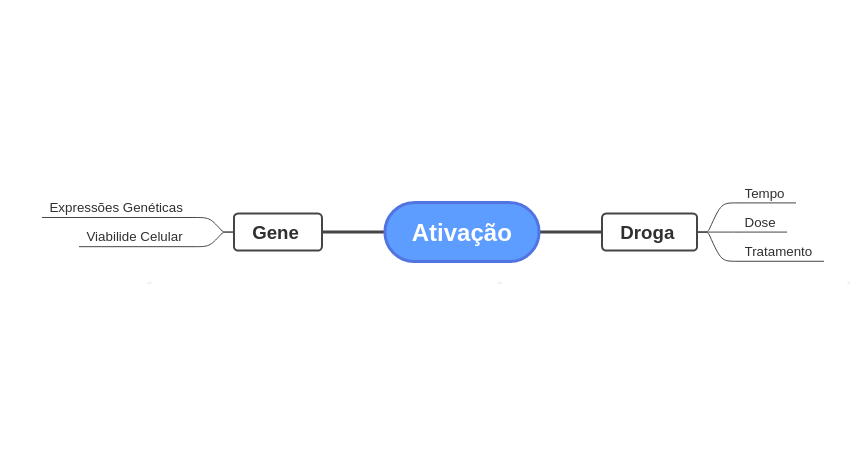

In [21]:
Image('https://raw.githubusercontent.com/tadeucbm/imersao-dados-desafio-final/main/img/MindMapHypothesis.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Gene

**1.** Maior média dos valores de viabilidade celular implica em mais ativações

**2.** Uma maior quantidade de expressões genéticas implica em mais ativações

### 2.2.2. Droga

**1.** Tratamentos com controle não possuem ativações

**2.** D2 ativa mais que D1

**3.** Um maior período de efeito da droga implica em mais ativações

### 2.2.3. Lista Final

**1.** Maior média dos valores de viabilidade celular implica em mais ativações

**2.** Uma maior quantidade de expressões genéticas implica em mais ativações

**3.** Tratamentos com controle não possuem ativações

**4.** D2 ativa mais que D1

**5.** Um maior período de efeito da droga implica em mais ativações

## 2.3. Feature Engineering

In [22]:
# contagem de moa's por cultura de célula
df_result['n_moa'] = df_result.select_dtypes('int64').sum(axis=1)

# se o moa ativa ou não
df_result['ativo_moa'] = [0 if value == 0 else 1 for value in df_result['n_moa']]

# media dos valores de c
df_exp['mean_c'] = df_exp.iloc[:, 777:].mean(axis=1)

# media dos valores de g
df_exp['mean_g'] = df_exp.iloc[:, 5:777].mean(axis=1)

In [23]:
# merge dos conjuntos de dados
df_2 = pd.merge(df_exp, df_result[['id', 'n_moa', 'ativo_moa']], on='id')

# 3.0. ANALISE EXPLORATORIA DE DADOS

Como as variáveis se comportam em relação ao fenômeno estudado?

A **Análise Exploratória de Dados** é o momento de buscar relações, entender o funcionamento dos dados e contestar as hipóteses levantadas na etapa anterior.

In [25]:
df_3 = df_2.copy()

## 3.1. Análise Univariada

### 3.1.1. Variável Resposta

Text(0.5, 1.0, '')

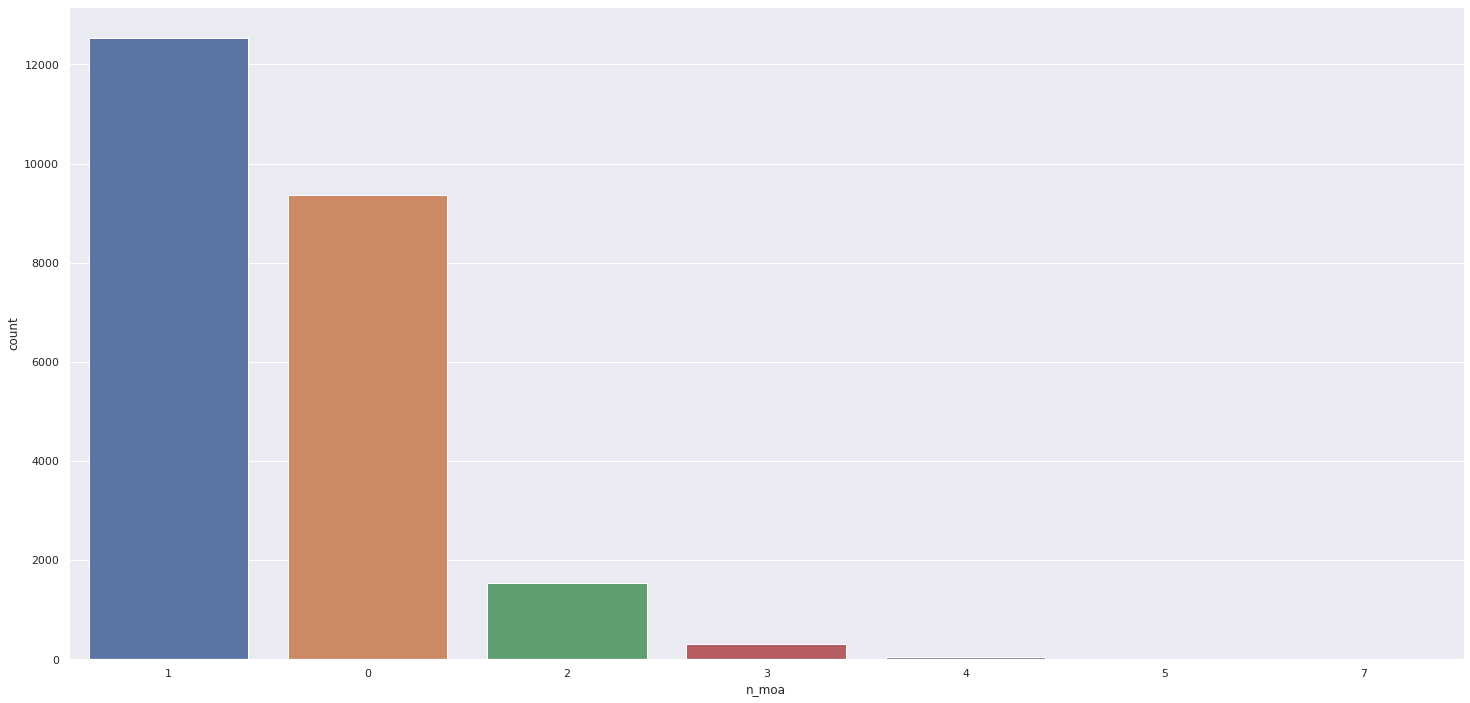

In [26]:
# # Plot de frequência dos MOA's
sns.countplot(x = df_3['n_moa'],
              order = df_3['n_moa'].value_counts().index)
plt.title('')

In [27]:
df_3['n_moa'].value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
Name: n_moa, dtype: int64

In [28]:
df_3['n_moa'].unique()

array([1, 0, 3, 2, 4, 5, 7])

<AxesSubplot:xlabel='ativo_moa', ylabel='count'>

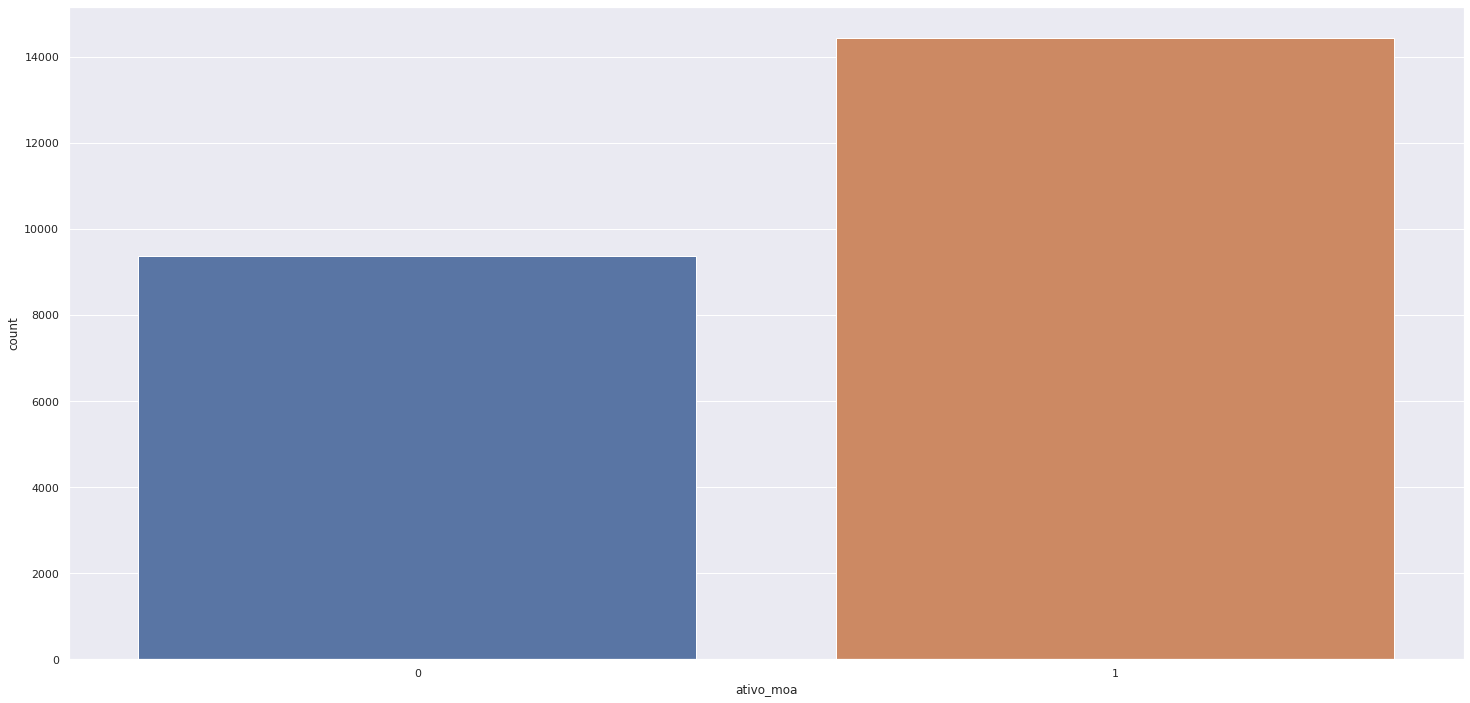

In [29]:
sns.countplot(x = df_3['ativo_moa'])

- A ocorrência modal é a de 3 ativações;
- Ativações de maior grau são menos comuns;
- Existe uma considerável quantidade de dados sem ativações;
- A variável resposta(ativação) é desbalanceada. Existem consideravelmente mais casos onde ocorrem ativações.

### 3.1.2. Variáveis Numéricas

Como os dados referentes a Viabilidade de Celular e a Expressão Genética estão presentes em grandes quantidades, serão selecionadas algumas amostras aleatórias para análise.

In [30]:
# Selecionando 10 Expressões Genéticas Aleatórias
df_g = df_3.iloc[:, 5:-104]
samples_df_g = df_g.sample(12, axis=1, random_state=25)

In [31]:
# Selecionando 10 Viabilidades Celulares Aleatórias
df_c = df_3.iloc[:, 777:-4]
samples_df_c = df_c.sample(12, axis=1, random_state=25)

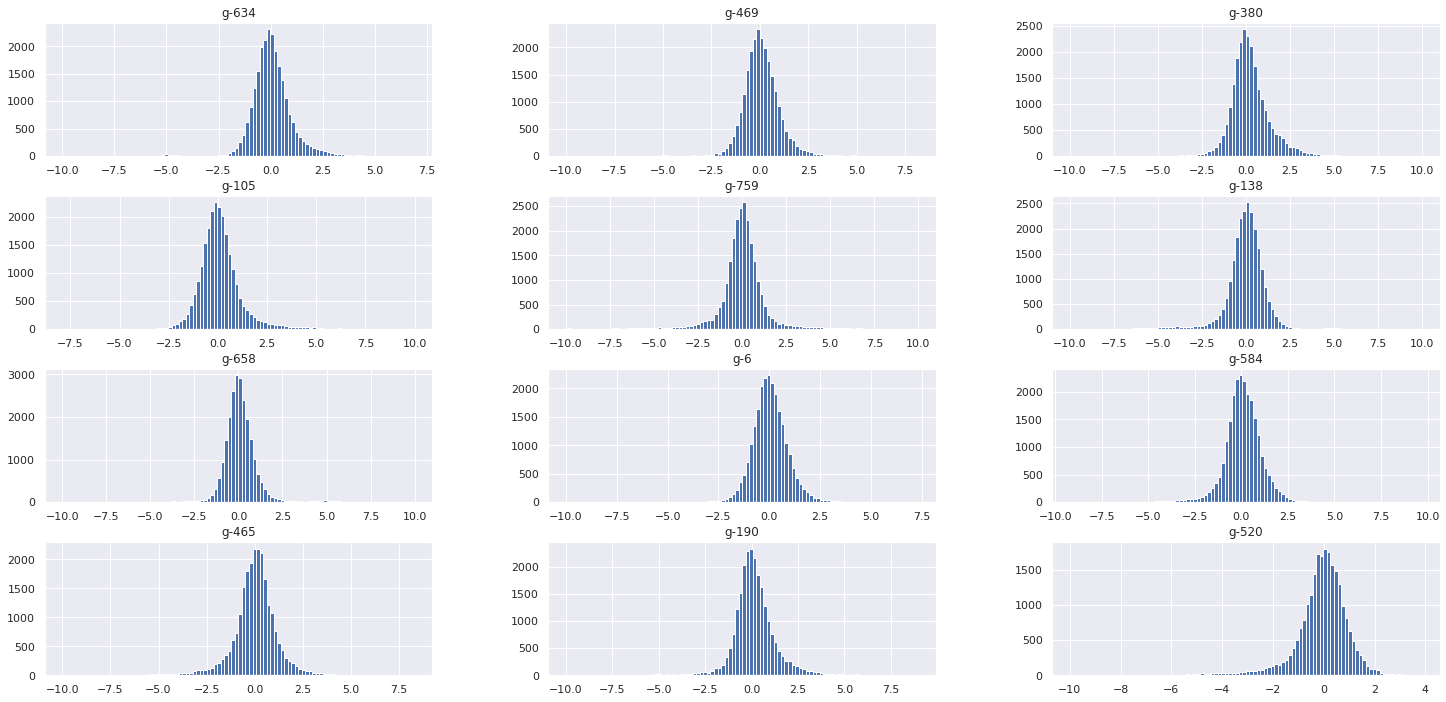

In [32]:
samples_df_g.hist(bins=100);

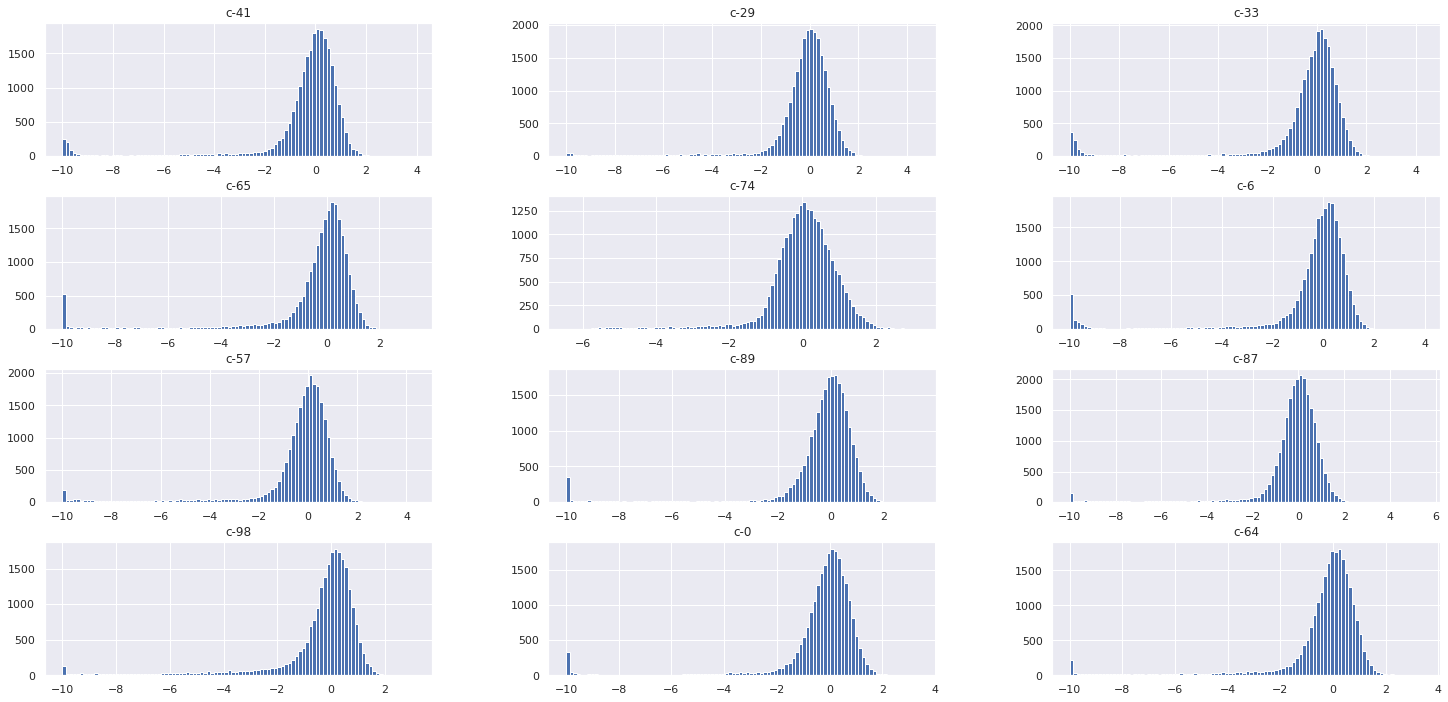

In [33]:
samples_df_c.hist(bins=100);

- Ambos os tipos de dados (g e c) estão normalizados em 0;
- Algumas samples possuem certo alongamento na calda em algum dos lados, porém reduzidas;
- Algumas samples possuem quantidades aumentados em Viabilidades Celulares mais baixas.

<AxesSubplot:xlabel='mean_g'>

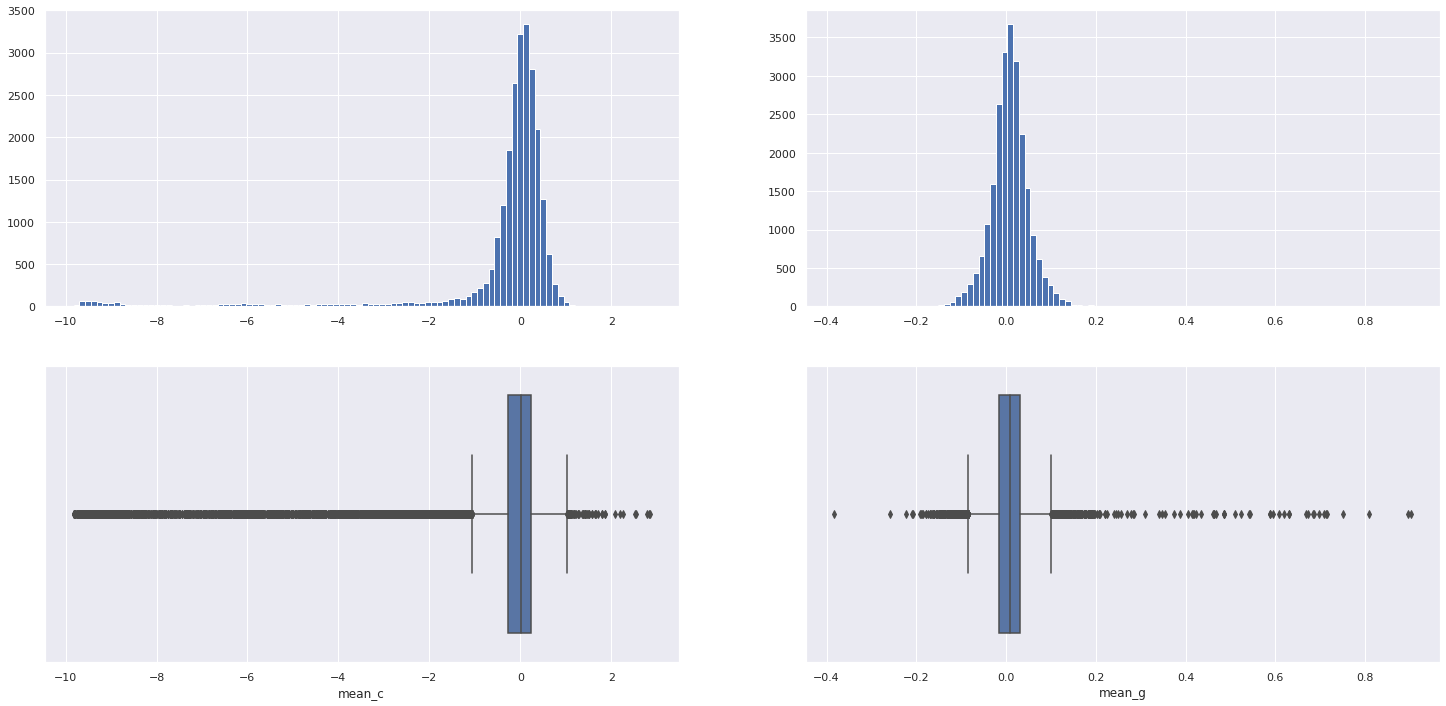

In [34]:
grid = plt.GridSpec(2, 2)

plt.subplot(grid[0, 0])
df_3.loc[:, 'mean_c'].hist(bins=100);

plt.subplot(grid[0, 1])
df_3.loc[:, 'mean_g'].hist(bins=100);

plt.subplot(grid[1, 0])
sns.boxplot(x = df_3.loc[:, 'mean_c'])

plt.subplot(grid[1, 1])
sns.boxplot(x = df_3.loc[:, 'mean_g'])

- A distribuição das médias, tanto de c quanto de g, se aproximam de uma normal
- Entretanto existem vários outliers.

### 3.1.3. Variáveis Categóricas

In [35]:
cat_var = df_3.loc[:, ['tratamento', 'tempo', 'dose', 'droga']]

#### Tratamento

In [36]:
com_droga = cat_var['tratamento'].value_counts(normalize=True)[0]
com_controle = cat_var['tratamento'].value_counts(normalize=True)[1]

<AxesSubplot:xlabel='tratamento', ylabel='count'>

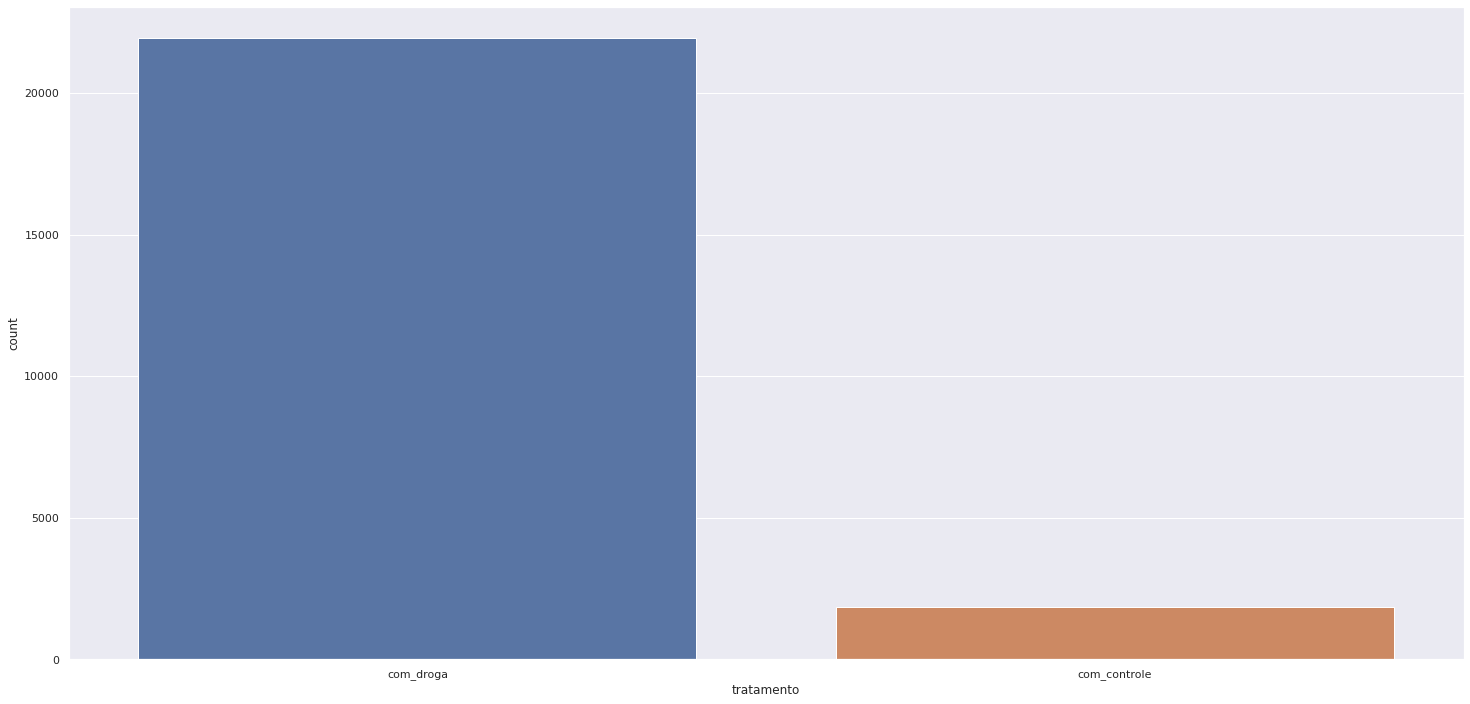

In [37]:
sns.countplot(x = cat_var['tratamento'])

In [38]:
print(f'Proporção dos dados com controle: {com_controle:.4f}')
print(f'Proporção dos dados com droga: {com_droga:.4f}')

Proporção dos dados com controle: 0.0784
Proporção dos dados com droga: 0.9216


- Tratamento é uma variável altamente desbalanceada.
- Existem muito mais casos de testes com droga do que com controle

#### Tempo

In [39]:
t_48 = cat_var['tempo'].value_counts(normalize=True).values[0]
t_72 = cat_var['tempo'].value_counts(normalize=True).values[1]
t_24 = cat_var['tempo'].value_counts(normalize=True).values[2]

<AxesSubplot:xlabel='tempo', ylabel='count'>

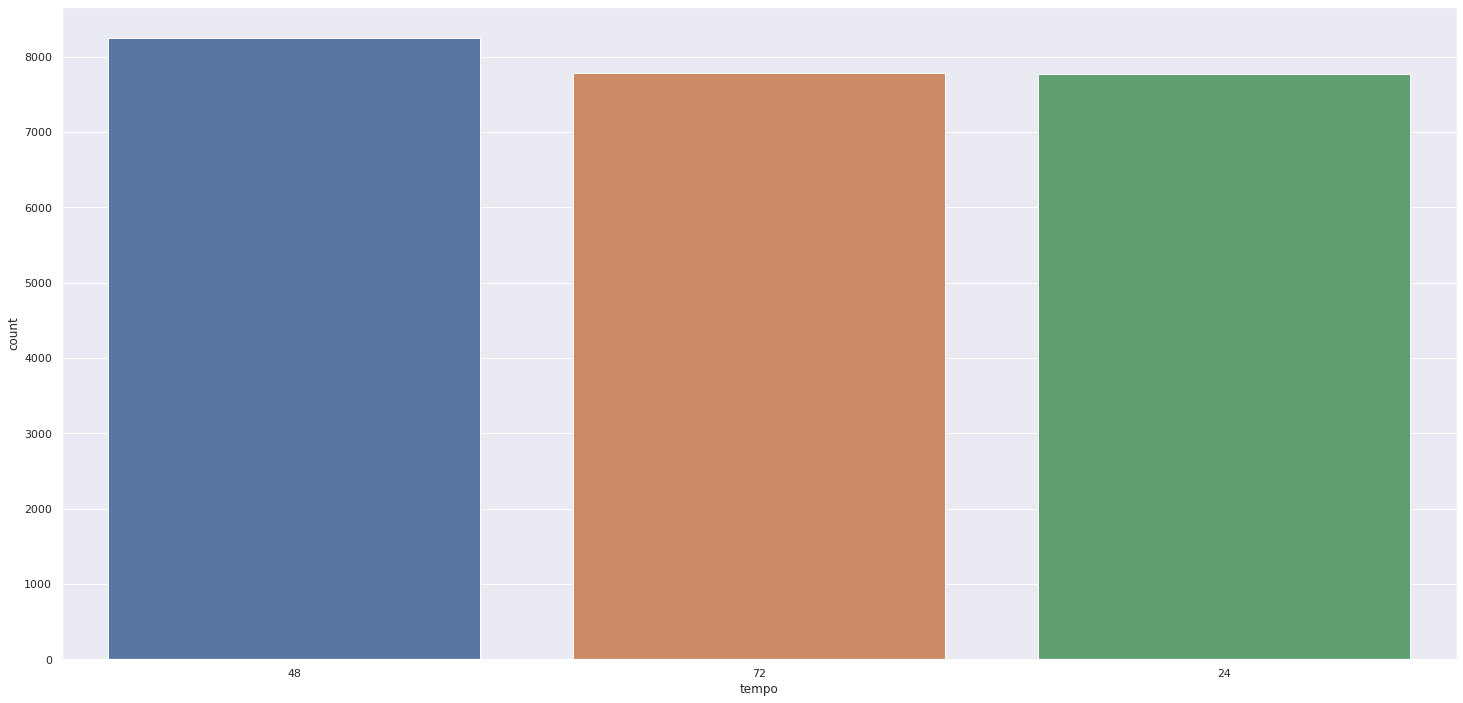

In [40]:
sns.countplot(x = cat_var['tempo'],
              order = cat_var['tempo'].value_counts().index)

In [41]:
print(f'Proporção dos dados com 24h: {t_24:.4f}')
print(f'Proporção dos dados com 48h: {t_48:.4f}')
print(f'Proporção dos dados com 72h: {t_72:.4f}')

Proporção dos dados com 24h: 0.3264
Proporção dos dados com 48h: 0.3464
Proporção dos dados com 72h: 0.3272


- A variável tempo é consideravelmente balanceada;
- O valor de maior ocorrência é de 48h

#### Dose

In [42]:
d1 = cat_var['dose'].value_counts(normalize=True)[0]
d2 = cat_var['dose'].value_counts(normalize=True)[1]

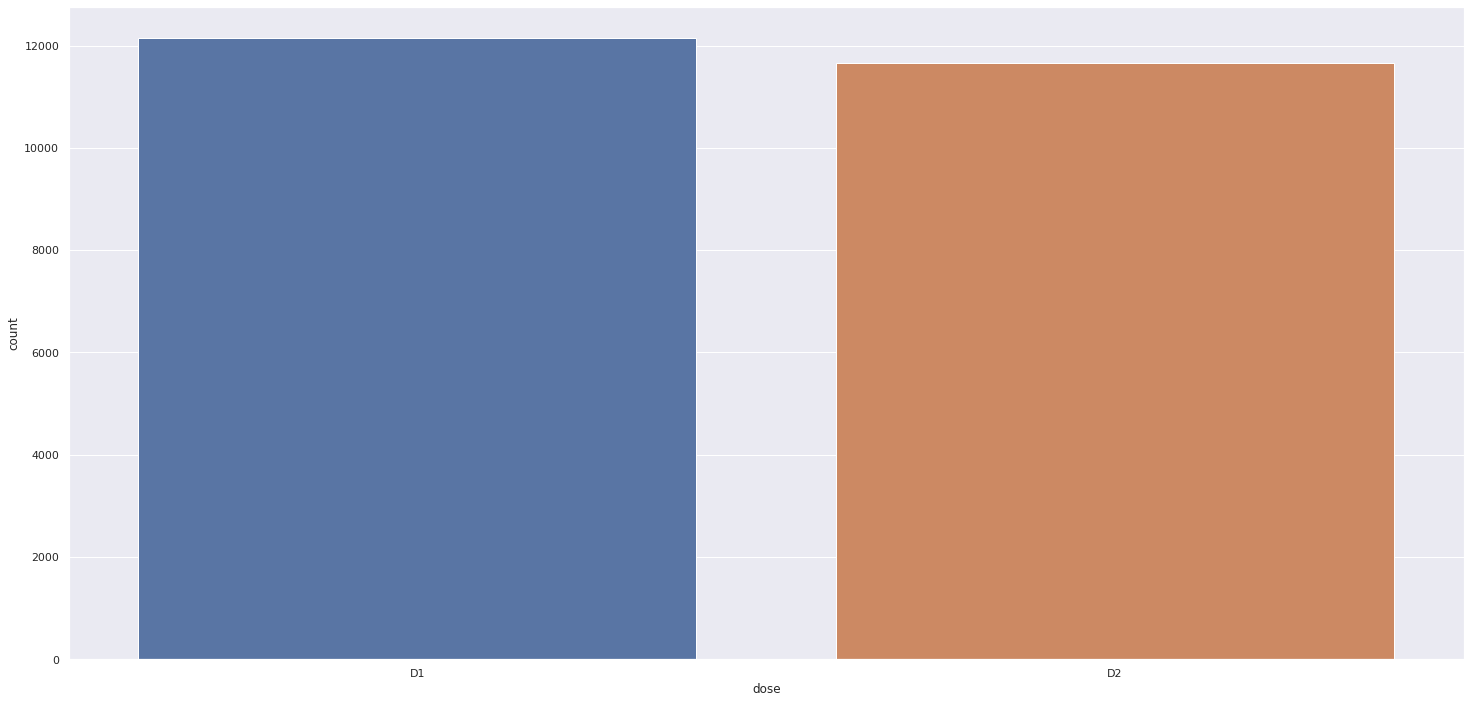

In [43]:
sns.countplot(x = cat_var['dose']);

In [44]:
print(f'Proporção dos dados D1: {d1:.4f}')
print(f'Proporção dos dados D2: {d2:.4f}')

Proporção dos dados D1: 0.5101
Proporção dos dados D2: 0.4899


- Dose é uma variável balanceada;
- D1 tem poucos casos a mais.

#### Droga

Como existem muitas drogas, a análise será feita apenas com as que possuem mais de 100 ocorrências

In [45]:
cat_var['droga'].value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
82dcdb180       1
98c94f9b9       1
5cc5a5a19       1
a8ec8311e       1
d532d49de       1
Name: droga, Length: 3289, dtype: int64

<AxesSubplot:xlabel='index', ylabel='droga'>

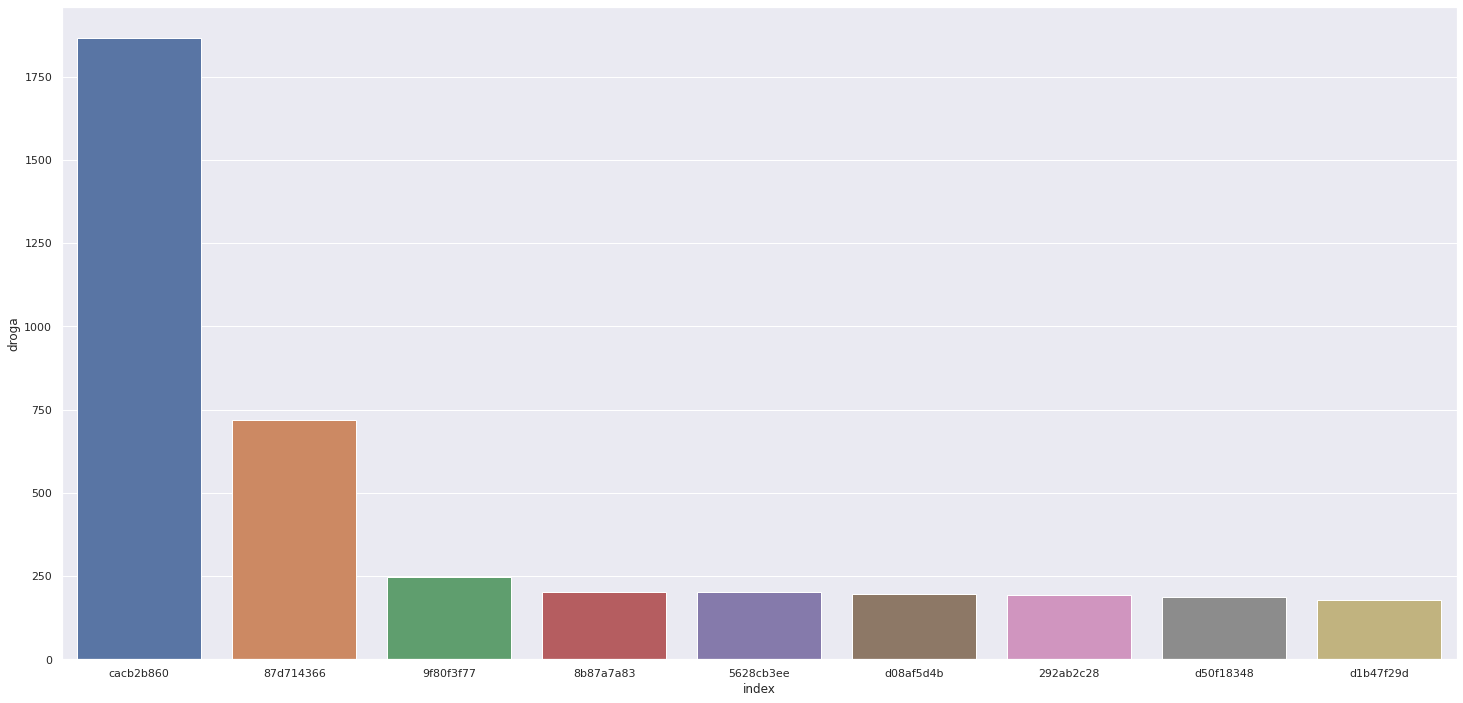

In [46]:
aux_1 = cat_var['droga'].value_counts().reset_index()
sns.barplot(x='index', y='droga', data=aux_1[0:9])

In [47]:
cat_var[df_exp['tratamento'] == 'com_controle']['droga'].unique()

array(['cacb2b860'], dtype=object)

In [48]:
cat_var['droga'].value_counts().median()

6.0

- A variável tratamento possui 3289 possíveis entradas
- O valor mediano de frequência é 6 (não foi usado média pois os dados possuem muitos outliers)
- A droga com maior frequência é o controle(que é a ausência de droga)
- Apenas 10, das 3289 drogas, têm frequência superior a 100

## 3.2. Análise Bivariada

### H1. Maior média dos valores de viabilidade celular implica em mais ativações - FALSO

- Pouca coisa se pode concluir com a média de viabilidade celular. No entanto, existe uma tendência das médias assumirem valores negativos.
- 7 Ativações é um evento raro. Apesar de apresentar um resultado interessante, não é possível assumir nada.
- **2 Ativações merece atenção. Possui uma quantidade razoável de dados e apresenta uma média do valor de viabilidade celular consideravelmente baixa**

In [49]:
aux_1 = df_3[['n_moa', 'mean_c']].groupby('n_moa').mean().reset_index()

<AxesSubplot:xlabel='n_moa', ylabel='mean_c'>

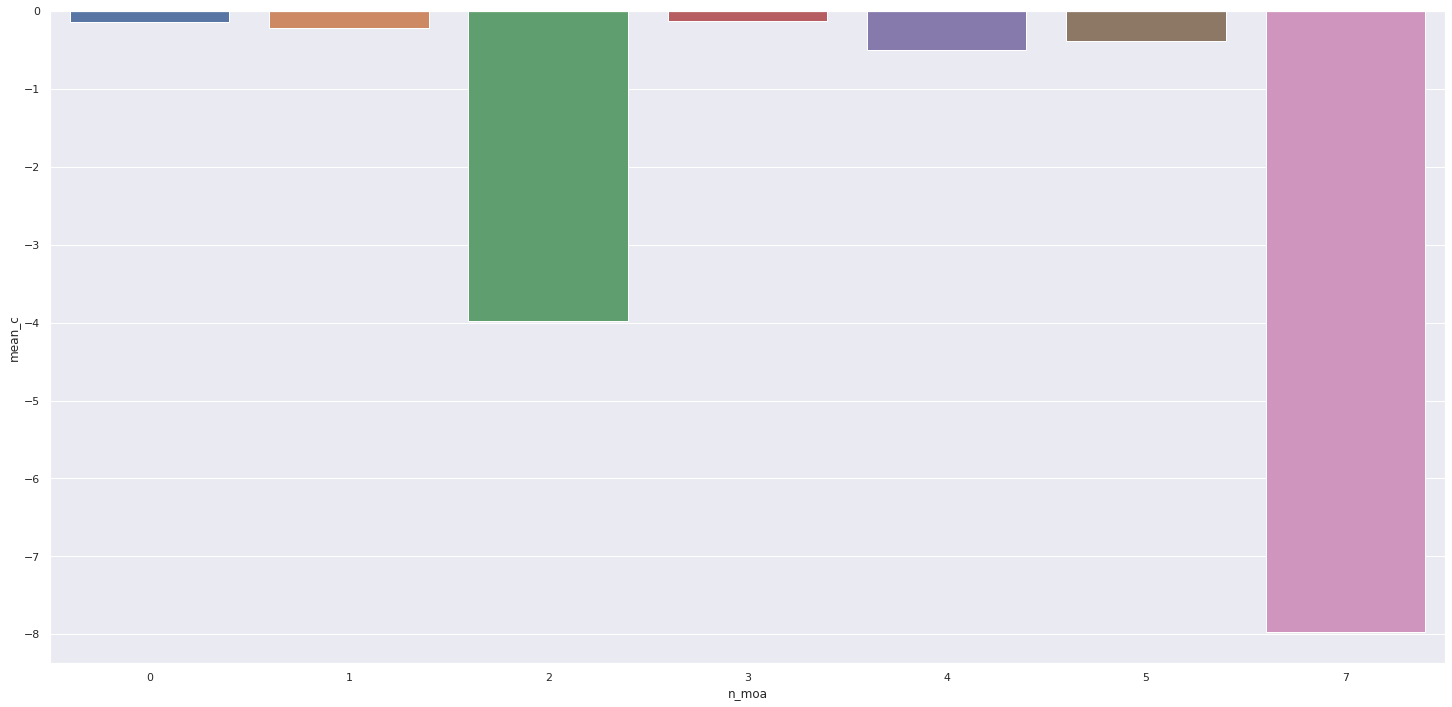

In [50]:
sns.barplot(x='n_moa', y='mean_c', data=aux_1)

### H2. Uma maior quantidade de expressões genéticas implica em mais ativações - FALSO
- Pouca coisa se pode concluir com o valor médio das expressões genéticas.

In [51]:
aux_1 = df_3[['n_moa', 'mean_g']].groupby('n_moa').mean().reset_index()

<AxesSubplot:xlabel='n_moa', ylabel='mean_g'>

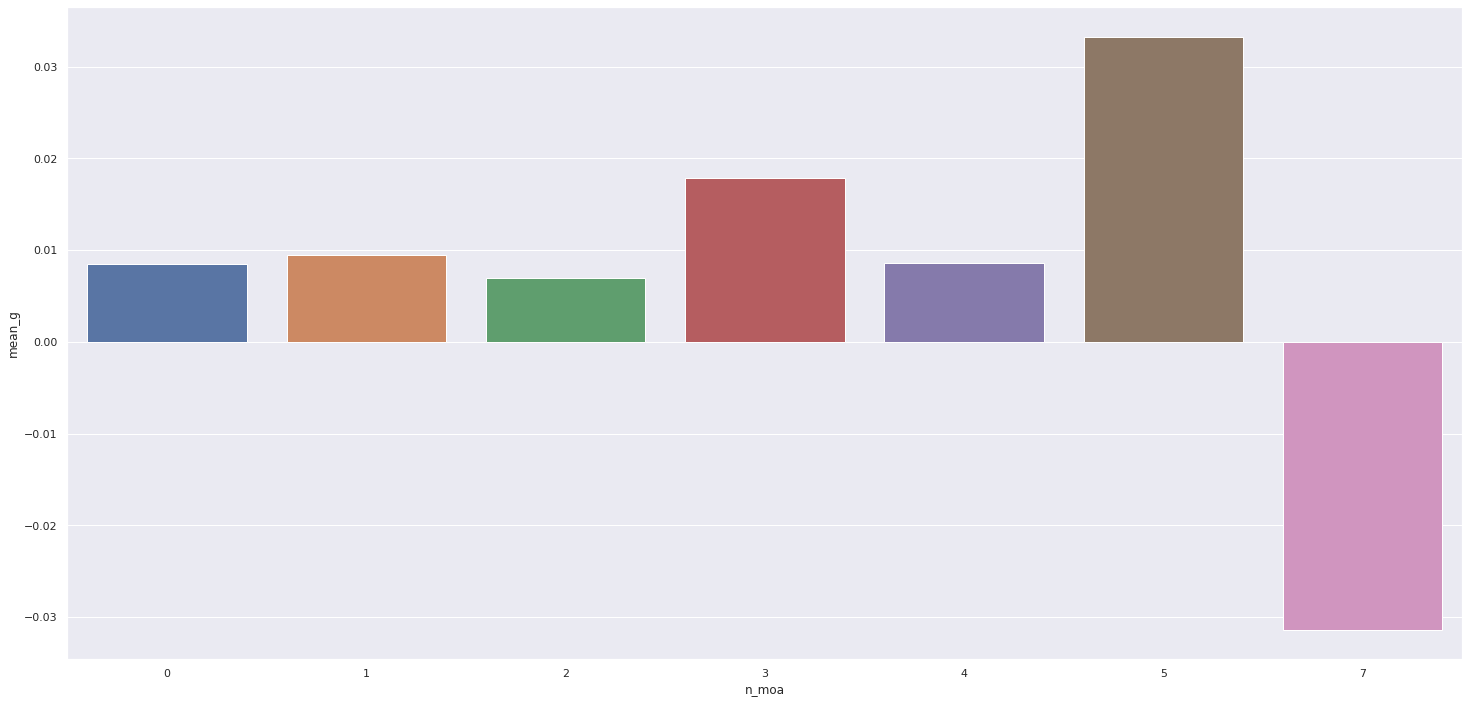

In [52]:
sns.barplot(x='n_moa', y='mean_g', data=aux_1)

### H3. Tratamentos com controle não possuem ativações - VERDADEIRO

- Como o esperado, as culturas que utilizaram controle não tiveram ativações.

In [53]:
aux_1 = df_3[['ativo_moa', 'tratamento']].groupby('tratamento').sum().reset_index()
aux_1

,tratamento,ativo_moa
0,com_controle,0
1,com_droga,14447


### H4. D2 ativa mais que D1 - FALSO

- D1 ativa mais que D2, porém a proporção é praticamente identica.

In [54]:
aux_1 = df_3[['dose', 'ativo_moa']].groupby('dose').sum().reset_index()

<AxesSubplot:xlabel='dose', ylabel='ativo_moa'>

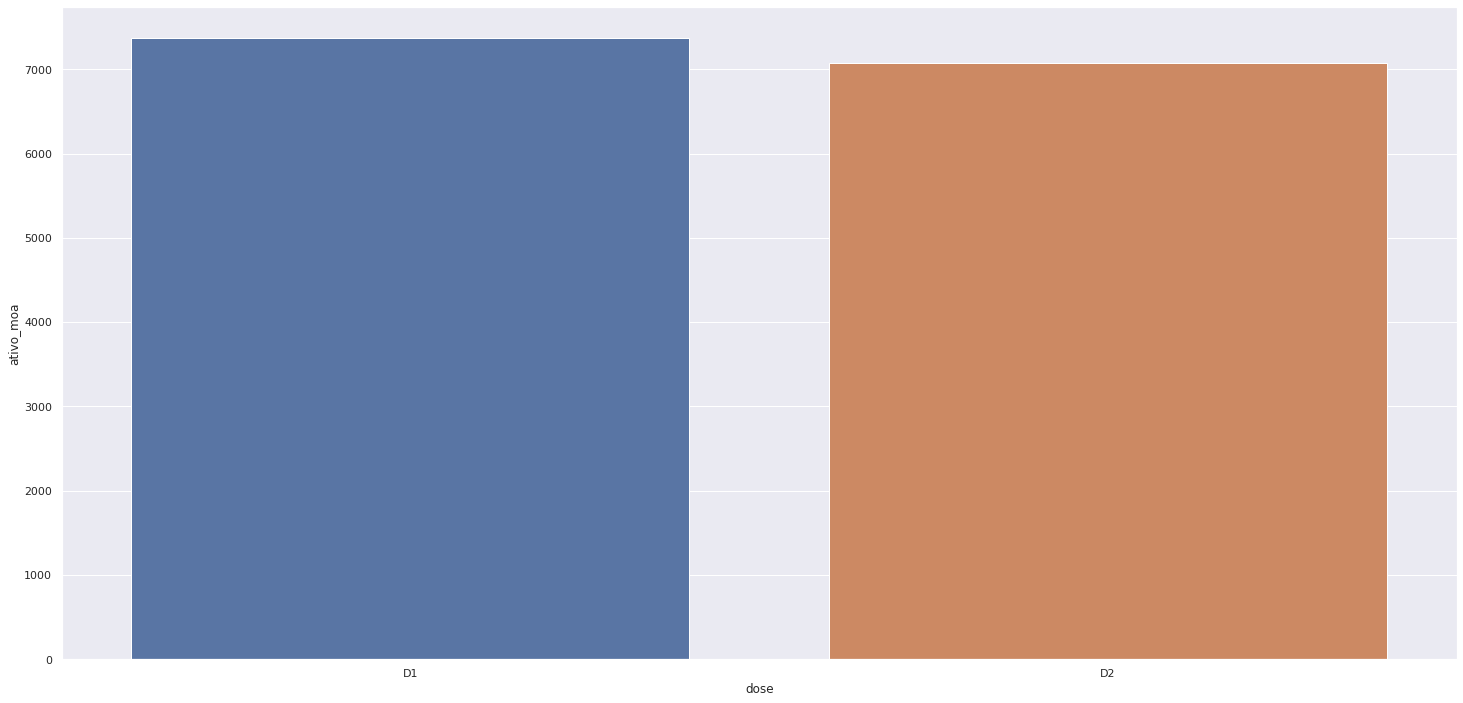

In [55]:
sns.barplot(x='dose', y='ativo_moa', data=aux_1)

### H5. Um maior período de efeito da droga implica em mais ativações - FALSO

- O período de efeito das drogas têm pouca relação com o número de ativações

In [56]:
aux_1 = df_3[['tempo', 'ativo_moa']].groupby('tempo').sum().reset_index()

<AxesSubplot:xlabel='tempo', ylabel='ativo_moa'>

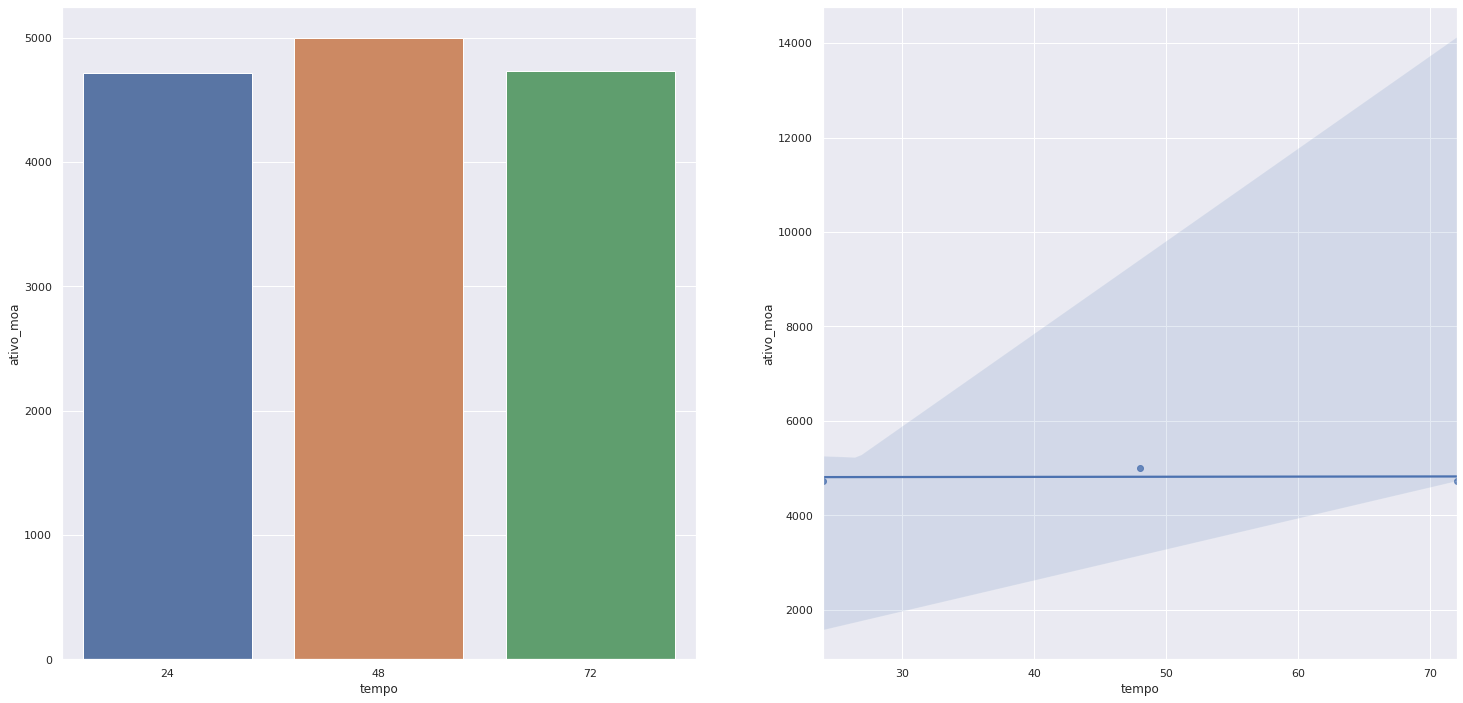

In [57]:
plt.subplot(1, 2, 1)
sns.barplot(x='tempo', y='ativo_moa', data=aux_1)

plt.subplot(1, 2, 2)
sns.regplot(x='tempo', y='ativo_moa', data=aux_1)

## 3.3. Análise Multivariada

In [61]:
cat_attributes = df_3.loc[:, ['tratamento', 'tempo', 'dose', 'ativo_moa']].astype('str')

<AxesSubplot:>

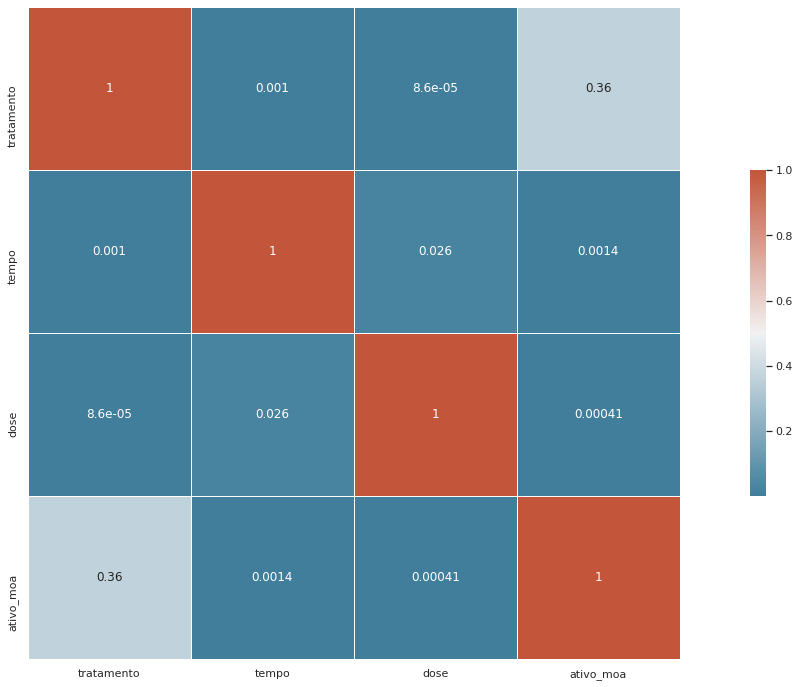

In [62]:
cat = {}

for value in cat_attributes.columns:
    cols = []
    for value_ in cat_attributes.columns:
        cols.append(cramer_v(cat_attributes[value], cat_attributes[value_]))
        
    cat[value] = cols
    
d = pd.DataFrame(cat)

d = d.set_index(d.columns)

# Plot
sns.heatmap(d, cmap=sns.diverging_palette(230, 20, as_cmap=True), linewidths=.5, annot=True,
            square=True, cbar_kws={'shrink': .5})

- As variáveis categóricas possuem baixa correlação entre si.
- A variável resposta e o tratamento possuem uma correlação de 0.36. Essa baixa correlação ocorre pois boa parte das drogas não ativam. No entando, como já foi analisado, apenas drogas levam a ativação.

# 4.0. Preparação dos Dados

É na preparação dos dados que as variáveis são condicionadas para que possam performar bem no modelo de Machine Learning. As seguintes etapas são essenciais:
- **Separação dos Dados**: Os dados precisam ser separados entre treino e teste. Os dados de treino são os responsáveis por modelar o problema. Os dados de teste serão usados apenas para fazer as previsões. É importante que os dados de teste não entrem em contato com os de treino para que a análise fique enviesada;
- **Encoding**: Na etapa do Scalling devemos transformar as variáveis categóricas em numéricas. Alguns modelos de Machine Learning são compatíveis com dados categóricos.
- **Normalização**: Os dados numéricos devem estar normalizados para que não tenhamos problemas de escala durante os treinamentos. Os dados em questão já estão normalizados.

In [63]:
df_4 = df_3.copy()

## 4.1. Separação dos Dados

In [64]:
# Separação dos dados em X(variáveis independentes) e Y(variável depentente)
X = df_4.drop(['id', 'n_moa', 'droga', 'ativo_moa'], axis=1)
y = df_4.loc[:, ['ativo_moa']]

In [65]:
# Split do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32, stratify=y)

## 4.2.1 Encoding 

In [66]:
# tratamento -> One Hot Encoding
X_train = pd.get_dummies(X_train, prefix='tratamento', columns=['tratamento'], drop_first=True)
X_test = pd.get_dummies(X_test, prefix='tratamento', columns=['tratamento'], drop_first=True)

# tempo -> dummy encoding
tempo_dict = {24: 1, 48: 2, 72: 3}
X_train['tempo'] = X_train['tempo'].map(tempo_dict)
X_test['tempo'] = X_test['tempo'].map(tempo_dict)

# dose -> dummy Econding
X_train = pd.get_dummies(X_train, prefix='dose', columns=['dose'], drop_first=True)
X_test = pd.get_dummies(X_test, prefix='dose', columns=['dose'], drop_first=True)

# 5.0. Feature Selection

**A explicação mais simples é sempre preferível do que a mais complexa**. Esse é o princípio da **Navalha de Occam**. Entende-se de Occam que modelos complexos são passíveis de erros. Portanto, sempre devemos buscar a solução mais simples para um problema.

No contexto de Machine Learning, constantemente nos deparamos com variáveis que pouco dizem sobre o problema. É importante que o profissional de dados tenha a consciência de quais informações ele deverá usar. "Cortar pela raíz" os dados que não trazem informação é essencial.

As técnicas de **Feature Selection** seguem esse princípio. Como essa é uma etapa que demanda tempo e processamento, na análise desse projeto será feita um corte simples de variáveis. Será usado o modelo de **Random Forest** para encontrar as variáveis mais importantes para o problema.

Pelo baixo tempo de análise, valores que estiverem abaixo do primeiro quartil serão descartados. No entanto, as técnicas de Feature Selection são muito mais complexas do que isso. Elas demandam tempo de análise e um elevado processamento.

In [67]:
X_train_nn = X_train.values
y_train_nn = y_train.values.ravel()

In [68]:
# Treinando o modelo de RandomForestClassifier
rf_model = en.RandomForestClassifier(n_jobs = -1)
rf_model.fit(X_train_nn, y_train_nn)

# Criação de uma Series com os valores de importância
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

In [106]:
# Por ser uma variável correlacionada com a variável resposta, essa feature distorce a visualização do boxplot.
feat_analise = feat_importances.drop(['tratamento_com_droga'], axis=0)

<AxesSubplot:>

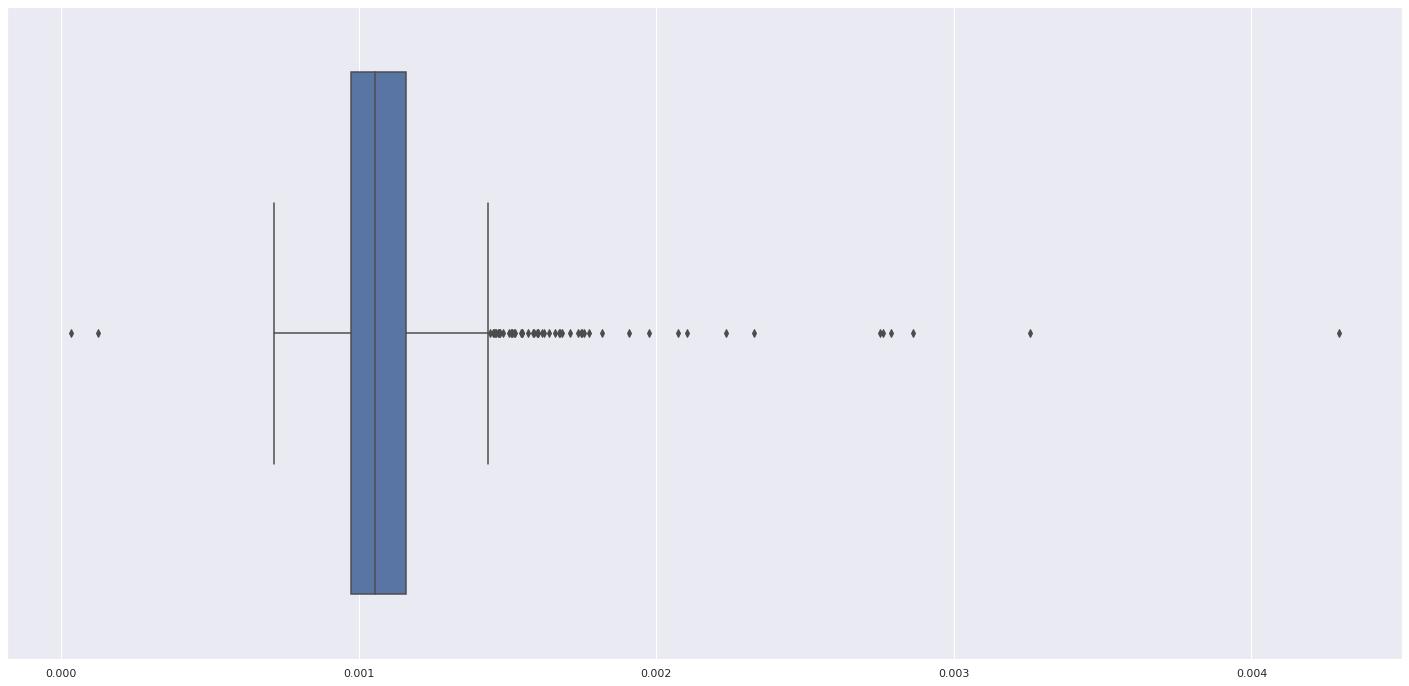

In [70]:
sns.boxplot(x = feat_analise)

In [72]:
# Selecionando apenas as features que estão acima do primeiro quartil
select_features = feat_importances[feat_importances > feat_importances.quantile([0.25,0.5,0.75]).values[0]]

# Lista final com as features que serão usadas para a modelagem
features_final = select_features.index.to_list()

X_train = X_train.loc[:, features_final]
X_test = X_test.loc[:, features_final]

# 6.0. Modelos de Machine Learning

É na modelagem que a mágica acontece. Aqui iremos "alimentar" os nossos modelos com os dados de treino. Dessa maneira, eles deverão encontrar padrões entre as variáveis independentes para que possam prever a variável resposta.

A estratégia desse projeto é utilizar alguns algorítmos de classificação:
- **LogisticRegression**
- **KNN**
- **GaussianNB**
- **LGBMClassifier**
- **RandomForestClassifier**
- **CatBoostClassifier**

Será utilizada a técnica de **Validação Cruzada**. O modelo cortará os dados em 5 Folds. Cada Fold será utilizado uma vez como variável resposta, e os demais como variáveis independentes. No final, a média desses resultados será a métrica utilizada para avaliar o modelo.

5 Métricas de avaliação de modelos de classificação foram escolhidas:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **ROC/AUC**

Todas serão utilizadas para a escolha o melhor modelo. Entretanto, a **Accuracy** será a métrica principal do projeto.

In [74]:
# separando os dados em folds:
kfold = StratifiedKFold(n_splits=5)

## 6.1. LogisticRegression

In [79]:
# criando o modelo:
modelo = LogisticRegression(max_iter=1000, random_state=25)

# Obtendo os resultados do cross_validation
resultado_lr = cross_validate(modelo, X_train, y_train.values.ravel(), cv = kfold, scoring=['precision', 'accuracy', 'recall', 'f1', 'roc_auc'])

In [80]:
# Tabela de resultados
df_resultado_lr = pd.DataFrame({'model': 'Logistic Regression',
                                'accuracy': resultado_lr['test_accuracy'].mean(),
                                'precision': resultado_lr['test_precision'].mean(),
                                'recall': resultado_lr['test_recall'].mean(),
                                'f1 score': resultado_lr['test_f1'].mean(),
                                'roc_auc': resultado_lr['test_roc_auc'].mean()}, index=[0])

df_resultado_lr

,model,accuracy,precision,recall,f1 score,roc_auc
0,Logistic Regression,0.672396,0.68294,0.858606,0.760754,0.699481


## 6.2. KNN

In [83]:
# criando o modelo:
modelo = KNeighborsClassifier(n_neighbors = 5)

# Obtendo os resultados do cross_validation
resultado_knn = cross_validate(modelo, X_train, y_train.values.ravel(), cv = kfold, scoring=['precision', 'accuracy', 'recall', 'f1', 'roc_auc'])

In [84]:
# Tabela de resultados
df_resultado_knn = pd.DataFrame({'model': 'KNN',
                                'accuracy': resultado_knn['test_accuracy'].mean(),
                                'precision': resultado_knn['test_precision'].mean(),
                                'recall': resultado_knn['test_recall'].mean(),
                                'f1 score': resultado_knn['test_f1'].mean(),
                                'roc_auc': resultado_knn['test_roc_auc'].mean()}, index=[0])

df_resultado_knn

,model,accuracy,precision,recall,f1 score,roc_auc
0,KNN,0.609295,0.654711,0.753392,0.700434,0.623796


## 6.3. GaussianNB

In [85]:
# criando o modelo:
modelo = nb.GaussianNB()

# Obtendo os resultados do cross_validation
resultado_nb = cross_validate(modelo, X_train, y_train.values.ravel(), cv = kfold, scoring=['precision', 'accuracy', 'recall', 'f1', 'roc_auc'])

In [86]:
# Tabela de resultados
df_resultado_nb = pd.DataFrame({'model': 'GaussianNB',
                                'accuracy': resultado_nb['test_accuracy'].mean(),
                                'precision': resultado_nb['test_precision'].mean(),
                                'recall': resultado_nb['test_recall'].mean(),
                                'f1 score': resultado_nb['test_f1'].mean(),
                                'roc_auc': resultado_nb['test_roc_auc'].mean()}, index=[0])

df_resultado_nb

,model,accuracy,precision,recall,f1 score,roc_auc
0,GaussianNB,0.473516,0.782963,0.183018,0.296526,0.656433


## 6.4. LGBMClassifier

In [87]:
# criando o modelo:
modelo = LGBMClassifier(n_jobs=-1)

# Obtendo os resultados do cross_validation
resultado_lgbm = cross_validate(modelo, X_train, y_train.values.ravel(), cv = kfold, scoring=['precision', 'accuracy', 'recall', 'f1', 'roc_auc'])

In [88]:
# Tabela de resultados
df_resultado_lgbm = pd.DataFrame({'model': 'LGBMClassifier',
                                'accuracy': resultado_lgbm['test_accuracy'].mean(),
                                'precision': resultado_lgbm['test_precision'].mean(),
                                'recall': resultado_lgbm['test_recall'].mean(),
                                'f1 score': resultado_lgbm['test_f1'].mean(),
                                'roc_auc': resultado_lgbm['test_roc_auc'].mean()}, index=[0])

df_resultado_lgbm

,model,accuracy,precision,recall,f1 score,roc_auc
0,LGBMClassifier,0.683035,0.673253,0.927826,0.780301,0.709707


## 6.5. RandomForestClassifier

In [89]:
# criando o modelo:
modelo = en.RandomForestClassifier(n_jobs=-1)

# Obtendo os resultados do cross_validation
resultado_rfc = cross_validate(modelo, X_train, y_train.values.ravel(), cv = kfold, scoring=['precision', 'accuracy', 'recall', 'f1', 'roc_auc'])

In [90]:
# Tabela de resultados
df_resultado_rfc = pd.DataFrame({'model': 'RandomForestClassifier',
                                'accuracy': resultado_rfc['test_accuracy'].mean(),
                                'precision': resultado_rfc['test_precision'].mean(),
                                'recall': resultado_rfc['test_recall'].mean(),
                                'f1 score': resultado_rfc['test_f1'].mean(),
                                'roc_auc': resultado_rfc['test_roc_auc'].mean()}, index=[0])

df_resultado_rfc

,model,accuracy,precision,recall,f1 score,roc_auc
0,RandomForestClassifier,0.681579,0.668559,0.942317,0.782168,0.684678


## 6.6. CatBoostClassifier

In [91]:
# criando o modelo:
modelo = cb.CatBoostClassifier(verbose=0)

# Obtendo os resultados do cross_validation
resultado_cbc = cross_validate(modelo, X_train, y_train.values.ravel(), cv = kfold, scoring=['precision', 'accuracy', 'recall', 'f1', 'roc_auc'])

In [92]:
# Tabela de resultados
df_resultado_cbc = pd.DataFrame({'model': 'CatBoostClassifier',
                                'accuracy': resultado_cbc['test_accuracy'].mean(),
                                'precision': resultado_cbc['test_precision'].mean(),
                                'recall': resultado_cbc['test_recall'].mean(),
                                'f1 score': resultado_cbc['test_f1'].mean(),
                                'roc_auc': resultado_cbc['test_roc_auc'].mean()}, index=[0])

df_resultado_cbc

,model,accuracy,precision,recall,f1 score,roc_auc
0,CatBoostClassifier,0.692217,0.671114,0.966128,0.792041,0.70745


## 6.7. Resultados

In [93]:
# Concatenando os resultados
pd.concat([df_resultado_lr,
           df_resultado_knn,
           df_resultado_nb,
           df_resultado_lgbm,
           df_resultado_rfc,
           df_resultado_cbc], axis=0).sort_values(by='accuracy', ascending=False)

,model,accuracy,precision,recall,f1 score,roc_auc
0,CatBoostClassifier,0.692217,0.671114,0.966128,0.792041,0.707450
0,LGBMClassifier,0.683035,0.673253,0.927826,0.780301,0.709707
0,RandomForestClassifier,0.681579,0.668559,0.942317,0.782168,0.684678
0,Logistic Regression,0.672396,0.682940,0.858606,0.760754,0.699481
0,KNN,0.609295,0.654711,0.753392,0.700434,0.623796
0,GaussianNB,0.473516,0.782963,0.183018,0.296526,0.656433


Para os objetivos da nossa análise e por entender as limitações de processamento e tempo, o modelo **LGBMClassifier** será o escolhido. Apesar do CatBoostClassifier ter obtido uma maior acurácia, ele demanda um processamento alto e não seria viável para o projeto.

O **LGBMClassifier** Possui um bom desempenho com esse tipo de dados. A acurácia está razoavelmente próxima do primeiro colodado. Além disso, a etapa de Fine Tunning elevará o desempenho do modelo.

# 7.0. Fine Tunning

In [96]:
# Definindo valores que serão testados no KNN:
learning_rate = np.linspace(1e-3, 1e-1, 15) # Quantiaded de vizinhos
num_leaves = np.linspace(6, 62, 4, dtype='int64') # calculos de distância
min_child_samples = np.linspace(1, 500, 10, dtype='int64')
min_child_weight = [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1]
subsample = np.linspace(0.05, 1.0, 5)
colsample_bytree = np.linspace(0.1, 1, 5)

valores_grid = {'learning_rate': learning_rate,
                'num_leaves': num_leaves,
                'min_child_samples': min_child_samples,
                'min_child_weight': min_child_weight, 
                'subsample': subsample, 
                'colsample_bytree': colsample_bytree}

# Criação do modelo:
modelo = modelo = LGBMClassifier(n_jobs=-1)

# Criandos os grids:
gridLGBM = RandomizedSearchCV(estimator = modelo, param_distributions = valores_grid, cv = 5, n_iter=50)
gridLGBM.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.00807143, 0.01514286, 0.02221429, 0.02928571,
       0.03635714, 0.04342857, 0.0505    , 0.05757143, 0.06464286,
       0.07171429, 0.07878571, 0.08585714, 0.09292857, 0.1       ]),
                                        'min_child_samples': array([  1,  56, 111, 167, 222, 278, 333, 389, 444, 500]),
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0],
                                        'num_leaves': array([ 6, 24, 43, 62]),
                                        'subsample': array([0.05  , 0.2875, 0.525 , 0.7625, 1.    ])})

In [97]:
print('Melhor acurácia: ', gridLGBM.best_score_)

Melhor acurácia:  0.6936730123180291


In [99]:
gridLGBM.best_estimator_

LGBMClassifier(learning_rate=0.08585714285714285, min_child_samples=111,
               min_child_weight=0.01, num_leaves=6, subsample=0.7625)

# 8.0. Modelo Final

In [100]:
modelo_final = LGBMClassifier(n_jobs=-1, learning_rate=0.08585714285714285, min_child_samples=111,
               min_child_weight=0.01, num_leaves=6, subsample=0.7625)

In [104]:
modelo_final.fit(X_train, y_train.values.ravel())

LGBMClassifier(learning_rate=0.08585714285714285, min_child_samples=111,
               min_child_weight=0.01, num_leaves=6, subsample=0.7625)

In [105]:
modelo_final.score(X_train, y_train.values.ravel())

0.6977043673012318

In [ ]:
https://rockcontent.com/br/blog/navalha-de-occam/